In [18]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import math

import sys
sys.path.append('..')
from cpcv_util import *
from optuna_util import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
# 真値と予測値を比較して表示するためのユーティリティ関数
def display_true_vs_pred(series_true, series_pred, subtitle):
    df = pd.DataFrame({'true': series_true, 'pred': series_pred}).dropna()
    corr = np.corrcoef(df['true'], df['pred'])
    pred_std = df['pred'].std()
    pred_mean = df['pred'].mean()
    true_std = df['true'].std()
    true_mean = df['true'].mean()
    
    pred_max = pred_mean + 4*pred_std
    pred_min = pred_mean - 4*pred_std
    true_max = true_mean + 4*true_std
    true_min = true_mean - 4*true_std
    
    fig, ax = plt.subplots(2, 2, sharex='col', sharey = 'row',
                           gridspec_kw={'width_ratios': [2, 0.5], 'height_ratios': [2, 0.5]}, figsize=(6, 6))
    
    # 予測値のレンジごとに真値の平均をプロットして比例関係があることを確認する
    pred_sections = []
    true_means = []
    for i in range(17):
        _df = df[(df['pred'] >= pred_min + 0.5 * pred_std * i) & (df['pred'] < pred_min + 0.5 * pred_std * (i + 1))]
        pred_sections.append(pred_min + 0.5 * pred_std * i)
        true_means.append(_df['true'].mean())
    
    # 散布図をプロットする (予測対象にならなかったtrue値は0になっているのでそれを除外していることに注意)
    #ax[0, 0].scatter(df.loc[df['true'] != 0,'pred'], df.loc[df['true'] != 0, 'true'], s = 1)
    ax[0, 0].scatter(df['pred'], df['true'], s = 1)
    ax[0, 0].step(pred_sections, true_means, 'red', where='post')
    ax[0, 0].set_title(subtitle + f' (IC={corr[0][1]:0.4f})')
    ax[0, 0].set_xlabel("prediction")
    ax[0, 0].set_ylabel("truth")
    ax[0, 0].set_xlim([pred_min, pred_max])
    ax[0, 0].set_ylim([true_min, true_max])
    ax[0, 0].set_xticks([pred_mean, pred_mean - 2*pred_std, pred_mean - 4*pred_std, pred_mean + 2*pred_std, pred_mean + 4*pred_std])
    ax[0, 0].set_yticks([true_mean, true_mean - 2*true_std, true_mean - 4*true_std, true_mean + 2*true_std, true_mean + 4*true_std])
    ax[0, 0].grid(axis = 'both')
    ax[0, 0].axvline(0, color='red', linestyle='dotted', linewidth=1)
    ax[0, 0].axhline(0, color='red', linestyle='dotted', linewidth=1)
    
    # 0と予測した値を表示するとヒストグラムがまともに見えないので除外している
    ax[1, 0].hist(df.loc[df['true'] != 0, 'pred'], bins=50, range=[pred_min, pred_max])
    ax[1, 0].grid(axis = 'both')
    ax[1, 0].axvline(0, color='red', linestyle='dotted', linewidth=1)
    
    ax[0, 1].hist(df.loc[df['true'] != 0, 'true'], bins=50, orientation='horizontal', range=[true_min, true_max])
    ax[0, 1].grid(axis = 'both')
    ax[0, 1].axhline(0, color='red', linestyle='dotted', linewidth=1)
    
    ax[1, 1].remove()
    
    fig.show()

,x,y,y_noise
0,1.255665,0.950756,1.005653
1,-5.890464,0.382704,0.081246
2,-1.811983,-0.971055,-0.684901
3,-5.779146,0.482966,0.401895
4,5.152790,-0.904581,-0.982185
...,...,...,...
9995,2.393257,0.680420,0.523205
9996,4.178017,-0.860589,-0.727042
9997,1.733770,0.986749,1.373679
9998,4.244553,-0.892546,-1.030946


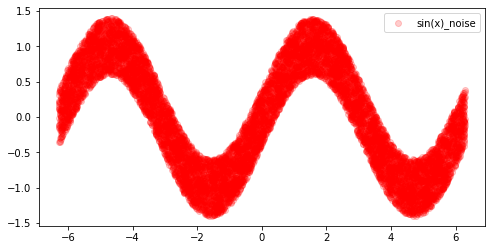

In [20]:
sample_size = 10000
#x = np.linspace(-10, 10, sample_size)
x = [random.uniform(-2 * math.pi, 2 * math.pi) for x in range(sample_size)]
y = np.sin(x)
y_noise = y + np.random.uniform(-0.4, 0.4, sample_size)

df = pd.DataFrame({'x': x, 'y': y, 'y_noise': y_noise})

plt.figure(figsize=[8, 4])
plt.scatter(df['x'], df['y_noise'], label='sin(x)_noise', color='red', alpha=0.2)
plt.legend()

display(df)

In [21]:
lgb_util = LightGBMRegressionUtil()

# Optunaを使わないシンプルなregression予測を行い、トレーニング区間を予測する
folds = cpcv_split(df)
lgb_util.train_cv(df[['x']], df['y_noise'], folds, use_optuna = False)
df['y_pred'] = lgb_util.predict(df[['x']], folds, predict_training = True)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


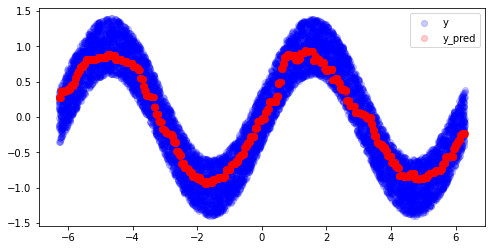

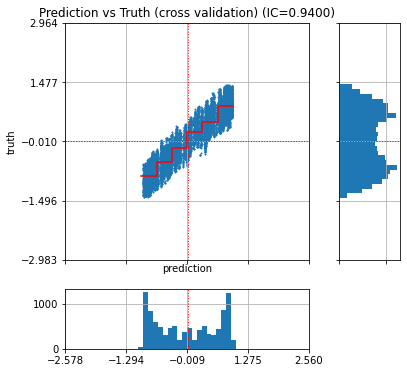

In [22]:
# 学習結果の表示
plt.figure(figsize=[8, 4])
plt.scatter(df['x'], df['y_noise'], label='y', alpha=.2, color='blue')
plt.scatter(df['x'], df['y_pred'], label='y_pred', alpha=.2, color='red')
plt.legend()

# 真値と予測値の関係を見る
display_true_vs_pred(df['y_noise'], df['y_pred'], 'Prediction vs Truth (cross validation)')

In [23]:
# Optunaを使わないシンプルなregression予測を行い、バリデーション区間を予測する
folds = cpcv_split(df)
lgb_util.train_cv(df[['x']], df['y_noise'], folds, use_optuna = False)
df['y_pred'] = lgb_util.predict(df[['x']], folds)

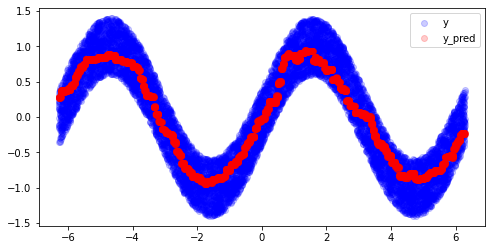

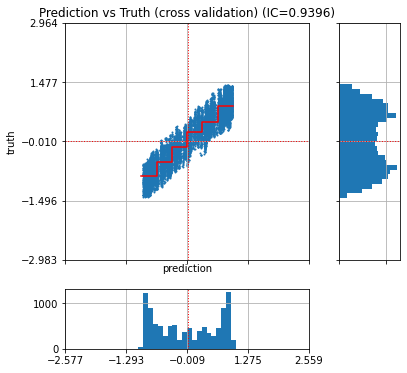

In [24]:
# 学習結果の表示
plt.figure(figsize=[8, 4])
plt.scatter(df['x'], df['y_noise'], label='y', alpha=.2, color='blue')
plt.scatter(df['x'], df['y_pred'], label='y_pred', alpha=.2, color='red')
plt.legend()

# 真値と予測値の関係を見る
display_true_vs_pred(df['y_noise'], df['y_pred'], 'Prediction vs Truth (cross validation)')

In [25]:
# Optunaを使ってregression予測を行い、トレーニング区間を予測する
folds = cpcv_split(df)
lgb_util.train_cv(df[['x']], df['y_noise'], folds, use_optuna = True)
df['y_pred'] = lgb_util.predict(df[['x']], folds, predict_training = True)

[I 2022-02-11 14:25:58,196] A new study created in memory with name: no-name-fb6cc3ad-dbe9-45d2-86ae-92a58baae26d
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-02-11 14:26:01,601] Trial 0 finished with value: 0.233932516617766 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.233932516617766.
/opt/conda/lib/py

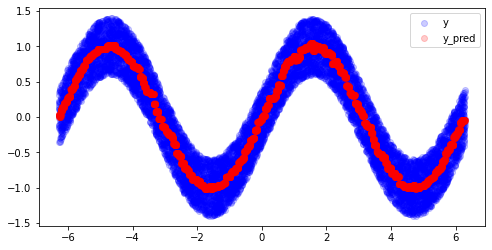

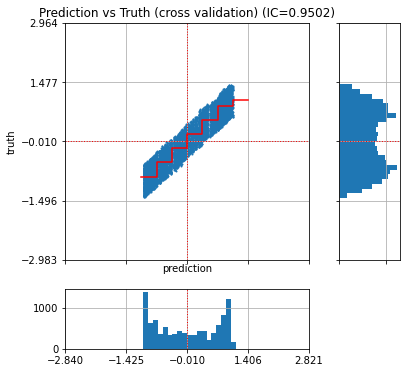

In [26]:
# 学習結果の表示
plt.figure(figsize=[8, 4])
plt.scatter(df['x'], df['y_noise'], label='y', alpha=.2, color='blue')
plt.scatter(df['x'], df['y_pred'], label='y_pred', alpha=.2, color='red')
plt.legend()

# 真値と予測値の関係を見る
display_true_vs_pred(df['y_noise'], df['y_pred'], 'Prediction vs Truth (cross validation)')

In [27]:
# Optunaで作った予測器をそのまま利用して、バリデーション区間を予測
df['y_pred'] = lgb_util.predict(df[['x']], folds)

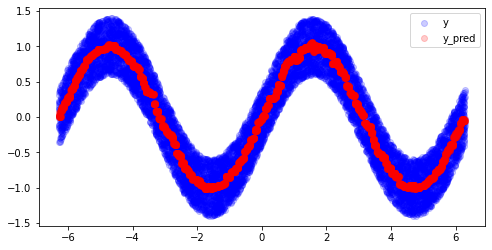

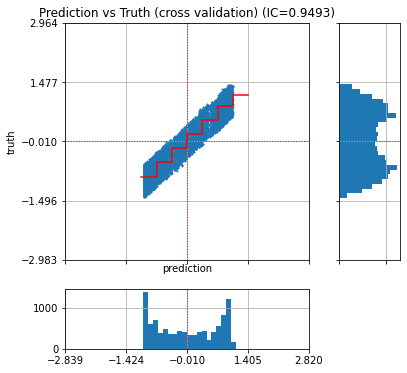

In [28]:
# 学習結果の表示
plt.figure(figsize=[8, 4])
plt.scatter(df['x'], df['y_noise'], label='y', alpha=.2, color='blue')
plt.scatter(df['x'], df['y_pred'], label='y_pred', alpha=.2, color='red')
plt.legend()

# 真値と予測値の関係を見る
display_true_vs_pred(df['y_noise'], df['y_pred'], 'Prediction vs Truth (cross validation)')

In [ ]:
# このテストコードにテスト区間はない